### Vicky van der Wagt

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: LDA, LDA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [9]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [16]:
# add any additional libaries you need here
nltk.download('brown')

import nltk
import tabulate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from matplotlib.colors import LinearSegmentedColormap

# define custom colormap for confusion matrices
colors = [(1, 1, 1), (1, 0, 1)]  # White to hot pink
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Robin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


In [17]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [18]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [19]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [20]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

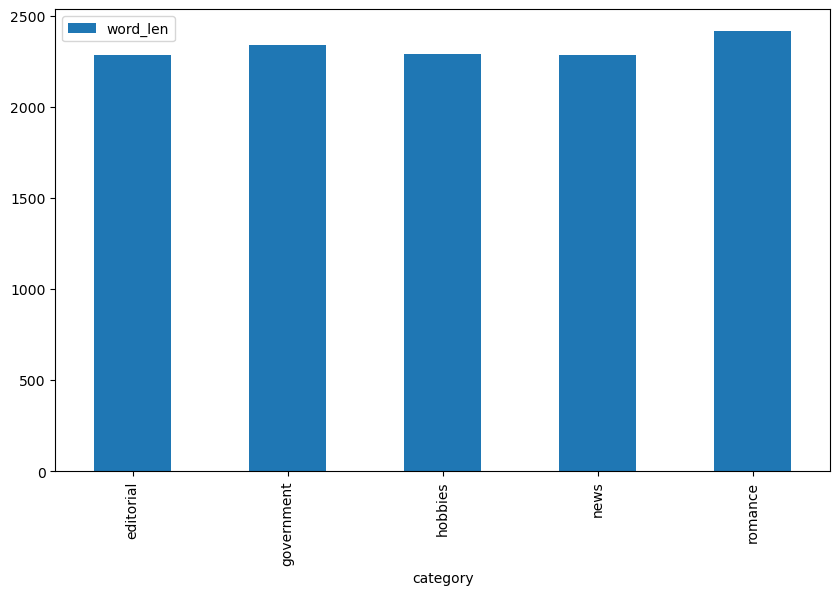

In [21]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [22]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [23]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: **count_text_vectors**: holds the count of each word

 **tfidf_text_vector**: holds the tfidf(term frequency-inverse document frequency) values. These values are the number of time that a term appears in a document, over the total nmber of terms. Therefore, they give insight to the importance of each word

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic LDA model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [24]:
NMF_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = NMF_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = NMF_text_model.components_

In [25]:
display_topics(NMF_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the LDA categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our LDA categorization agrees or disagrees with the original categories in the corpus. For each topic in your LDA model, tally the Brown categories and interpret the results. 


**Add LDA predicted labels as a column in our dataframe**

In [27]:
# generate dictionary to map topics and categories
topic_category_mapping = {
    0: "editorial",
    1: "government",
    2: "news",
    3: "romance",
    4: "hobbies"
}

predicted_topics = W_text_matrix.argmax(axis=1)

# create a new column in the df for the predicted categories
df['NMF_predicted_category'] = [topic_category_mapping[idx] for idx in predicted_topics]

# get unique category counts for actual and nmf predicted categories
category_counts = df['category'].value_counts()
nmf_predicted_category_counts = df['NMF_predicted_category'].value_counts()

nmf_actual_counts = pd.DataFrame({
    'category': category_counts,
    'NMF_predicted_category': nmf_predicted_category_counts
})

# investigate value counts of actual and distributed
nmf_actual_counts

,category,NMF_predicted_category
editorial,27,32
government,30,41
hobbies,36,10
news,44,65
romance,29,18


**Model Evaluation - confusion matrix and classification report**

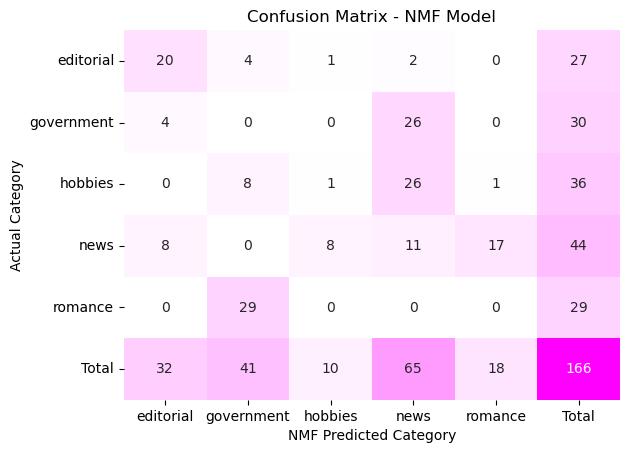

              precision    recall  f1-score   support

   editorial       0.62      0.74      0.68        27
  government       0.00      0.00      0.00        30
     hobbies       0.10      0.03      0.04        36
        news       0.17      0.25      0.20        44
     romance       0.00      0.00      0.00        29

    accuracy                           0.19       166
   macro avg       0.18      0.20      0.18       166
weighted avg       0.17      0.19      0.17       166



In [35]:
# extract actual and predicted results for comparison
actual_category = df['category'].astype(str)
NMF_predicted_category = df['NMF_predicted_category'].astype(str)

# sort labels for our confusion matrix
actual_labels_sorted = np.sort(actual_category.unique())
NMF_predicted_labels_sorted = np.sort(NMF_predicted_category.unique())

# generate confusion matrix, convert to dataframe for visualization
conf_matrix = confusion_matrix(actual_category, nmf_predicted_category)
conf_matrix_df = pd.DataFrame(conf_matrix, index=actual_labels_sorted, columns=NMF_predicted_labels_sorted)

# plot confusion matrix
conf_matrix_df['Total'] = conf_matrix_df.sum(axis=1)
conf_matrix_df.loc['Total'] = conf_matrix_df.sum(axis=0)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=custom_cmap, cbar=False)
plt.xlabel('NMF Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix - NMF Model')
plt.show()

conf_matrix

# generate classification report
print(classification_report(actual_category, nmf_predicted_category))

Q: How does your five-topic nmf model compare to the original Brown categories? 

A: Overall, the five-topic nmf model does not perform well overall. It attained an accuracy of 19% when compared with the actual category values. The best performance was observed in the editorial category.
* Editorial: The 'editorial' group had the highest precision, recall, and f1-score. Out of 27 actual 'editorial' files, 20 were classified correctly
* Government - The nmf model did not predict any 'government' category files correctly. Out of 30, 4 were predicted as editorial, and most were predicted as news.
* Hobbies - The nmf model also did not perform well in the 'hobby' category; it predicted nearly all as news.
* News - The nmf model predicted the highest number of files as news (65). However, only 11 of these were correct.
* Romance - Similar to the 'government' category, the nmf model did not predict any of the files correct in the romance category. It predicted nearly all of them as 'news'.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedLSA" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [36]:
# Your code here
LSA_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_LSA_para_matrix = LSA_para_model.fit_transform(tfidf_text_vectors)
H_LSA_para_matrix = LSA_para_model.components_

In [38]:
LSA_predicted_topics = W_LSA_para_matrix.argmax(axis=1)

# create a new column in the df for the predicted categories
df['LSA_predicted_category'] = [topic_category_mapping[idx] for idx in LSA_predicted_topics]

# get unique category counts for actual and LSA predicted categories
category_counts = df['category'].value_counts()
LSA_predicted_category_counts = df['LSA_predicted_category'].value_counts()

LSA_actual_counts = pd.DataFrame({
    'category': category_counts,
    'LSA_predicted_category': LSA_predicted_category_counts
})

# convert LSA prediction column to integer and fill null values with 0
LSA_actual_counts['LSA_predicted_category'] = LSA_actual_counts['LSA_predicted_category'].fillna(0).astype(int)


# investigate value counts of actual and distributed
LSA_actual_counts

,category,LSA_predicted_category
editorial,27,148
government,30,8
hobbies,36,7
news,44,0
romance,29,3


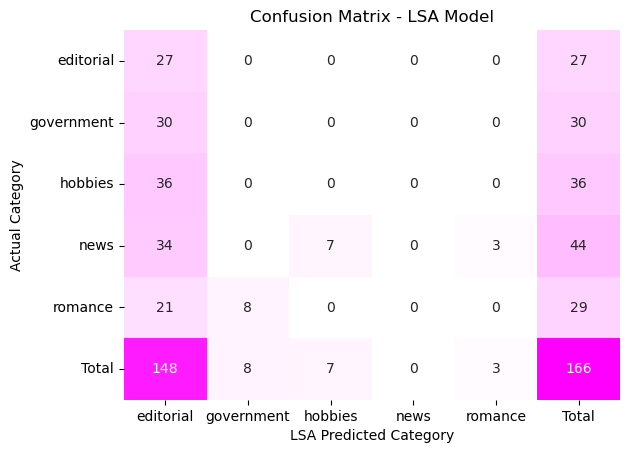

              precision    recall  f1-score   support

   editorial       0.18      1.00      0.31        27
  government       0.00      0.00      0.00        30
     hobbies       0.00      0.00      0.00        36
        news       0.00      0.00      0.00        44
     romance       0.00      0.00      0.00        29

    accuracy                           0.16       166
   macro avg       0.04      0.20      0.06       166
weighted avg       0.03      0.16      0.05       166



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# extract actual and predicted results for comparison
actual_category = df['category'].astype(str)
LSA_predicted_category = df['LSA_predicted_category'].astype(str)
# sort labels for our confusion matrix
actual_labels_sorted = np.sort(actual_category.unique())

# generate confusion matrix, convert to dataframe for visualization
conf_matrix = confusion_matrix(actual_category, LSA_predicted_category)
conf_matrix_df = pd.DataFrame(conf_matrix, index=actual_labels_sorted, columns=actual_labels_sorted)

# plot confusion matrix
conf_matrix_df['Total'] = conf_matrix_df.sum(axis=1)
conf_matrix_df.loc['Total'] = conf_matrix_df.sum(axis=0)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=custom_cmap, cbar=False)
plt.xlabel('LSA Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix - LSA Model')
plt.show()

conf_matrix

# generate classification report
print(classification_report(actual_category, LSA_predicted_category))

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model performed very poorly compared to the original Brown categories, with an overall accuracy of 16%. This is worse than the NMF value as well. It predicted 89% of the files as 'editorial', when in actuality, only 16% of the files are 'editorial'.

In [46]:
# call display_topics on your model
display_topics(LSA_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output? 

A: There are some mutual high contributing words in topics. For instance, Topic 0, 2, and 3 all contain 'mrs'; this word was weighed the highest of all words for topics 2 and 3. Additionally, 'mr' was found in topics 0 and 2. The word 'game' was also found in topics 3 and 4. This shows that the topics overlap quite a bit, which likely contributed to the poor classification.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [47]:
# Fit your LDA model here
LDA_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_LDA_para_matrix = LDA_para_model.fit_transform(count_text_vectors)
H_LDA_para_matrix = LDA_para_model.components_

In [52]:
LDA_predicted_topics = W_LDA_para_matrix.argmax(axis=1)

# create a new column in the df for the predicted categories
df['LDA_predicted_category'] = [topic_category_mapping[idx] for idx in LDA_predicted_topics]

# get unique category counts for actual and LDA predicted categories
category_counts = df['category'].value_counts()
LDA_predicted_category_counts = df['LDA_predicted_category'].value_counts()

LDA_actual_counts = pd.DataFrame({
    'category': category_counts,
    'LDA_predicted_category': LDA_predicted_category_counts
})

# convert LDA prediction column to integer and fill null values with 0
LDA_actual_counts['LDA_predicted_category'] = LDA_actual_counts['LDA_predicted_category'].fillna(0).astype(int)


# investigate value counts of actual and distributed
LDA_actual_counts

,category,LDA_predicted_category
editorial,27,28
government,30,38
hobbies,36,32
news,44,56
romance,29,12


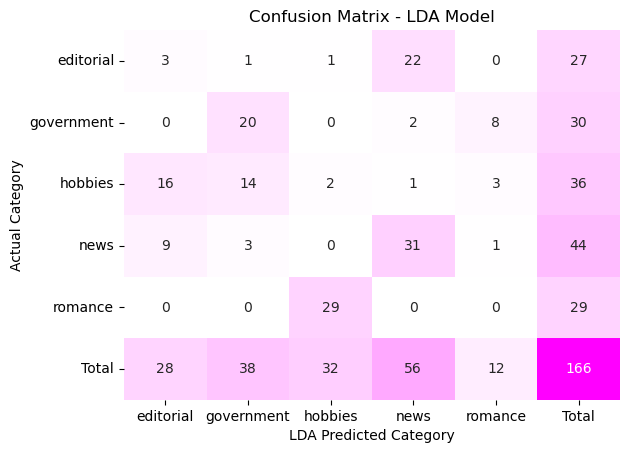

              precision    recall  f1-score   support

   editorial       0.11      0.11      0.11        27
  government       0.53      0.67      0.59        30
     hobbies       0.06      0.06      0.06        36
        news       0.55      0.70      0.62        44
     romance       0.00      0.00      0.00        29

    accuracy                           0.34       166
   macro avg       0.25      0.31      0.28       166
weighted avg       0.27      0.34      0.30       166



In [53]:
# extract actual and predicted results for comparison
actual_category = df['category'].astype(str)
LDA_predicted_category = df['LDA_predicted_category'].astype(str)
# sort labels for our confusion matrix
actual_labels_sorted = np.sort(actual_category.unique())

# generate confusion matrix, convert to dataframe for visualization
conf_matrix = confusion_matrix(actual_category, LDA_predicted_category)
conf_matrix_df = pd.DataFrame(conf_matrix, index=actual_labels_sorted, columns=actual_labels_sorted)

# plot confusion matrix
conf_matrix_df['Total'] = conf_matrix_df.sum(axis=1)
conf_matrix_df.loc['Total'] = conf_matrix_df.sum(axis=0)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=custom_cmap, cbar=False)
plt.xlabel('LDA Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix - LDA Model')
plt.show()

conf_matrix

# generate classification report
print(classification_report(actual_category, LDA_predicted_category))

In [54]:
# Call `display_topics` on your fitted model here
display_topics(LDA_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model?

A: The topics seem to be more distinct than in the previous LSA model. However, there are still overlapping words: 'state' is found in both topic 1 and topic 2. Additionally, 'said' has the most weight in topics 2 and 4.
* Topic 0: Seems to do with sports
* Topic 1: Has to do with development and states. 'State' and 'states' are both components; pre-processing the text could clean this up
* Topic 2: Has to do with president, formal titles
* Topic 3: Has to do more with different sectors
* Topic 4: Contains more words that could be used to describe man

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: The LDA model performs at 34%, better than baseline model* of 26.5%. It performs best in predicting files as 'government' and 'news' correctly, and has the worst performance on 'hobbies' and 'romance' categories.
* Assumes that baseline efficiency (26.5%) is where the model would predict each file to belong to the top class.

In [50]:
lda_display = pyLDAvis.lda_model.prepare(LDA_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [51]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: In pyLDAvis, bubbles that are further away from each other are more different. Therefore, we see that topics 1 and 5 are more individualized, while topic 2 has overlap between topic 3 and 4. Additionally, the bubble size represents the distribution of files in that topic; topic 3 has the most, and topic 4 has the least. In the salient terms graph, the red bar for each word indicates the frequency of the word, while the blue indicates the overall term frequency. Some insights about the invidivual topics:
* Topic 1: The top 2 words 'home' and 'right' appear often in other categories as well. The third most relevant term, 'game', is much more unique to this category. Other words that deal with sports or hobbies such as 'club', 'run', and 'ball' are also found in this category.
* Topic 2: The most relevant term in this category is 'state', which is incredibly frequent in this category but also overall. The other words have to deal with different sectors and development, with words such as 'program', 'development', 'national', 'system', 'medical', and 'government' as relevent terms.
* Topic 3: The most relevant term in this topic is 'said', which also appears often in other categories. Many words in this deal with presidential or formal titles and words used often in government speeches, including 'president', 'united', 'american', 'kennedy', etc.
* Topic 4: Despite having lots of overlap with topic 2, the word 'feed' (the most relevant term) is mostly unique to this category. Some of these words have to do with laws and business, such as 'property', 'shall', 'tax', etc. However, most of the terms are not very unique to this category.
* Topic 5: The top 3 words in this category are 'said', 'man', and 'little'. All these words are surprisingly short, and terms that often describe or have to do with people such as 'mother', 'young', 'eyes', etc. The most common work is 'said', although this words is found quite frequently in other categories as well.